In [1]:
"""Initialize all packages used"""
import time
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 140
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy.fft as fft
from scipy import signal
import statsmodels.api as sm

In [2]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [3]:
def E_field_None(t, r):
    """
    E_field returns the electric field vector at time t at position r.
    """
    x, y, z = r[0], r[1], r[2]
            
    Ex = 0
    Ey = 0
    Ez = 0
    
    E_field = np.array([Ex, Ey, Ez])
    return(E_field)

In [4]:
def E_field_Constant(t, r):
    """
    E_field_Constant returns the electric field vector at time t at position r, for a constant electric field
    """
    x, y, z = r[0], r[1], r[2]
            
    Ex = 0
    Ey = 0.1
    Ez = 0
    
    E_field = np.array([Ex, Ey, Ez])
    return(E_field)

In [5]:
def E_field_Time(t, r):
    """
    E_field returns the electric field vector at time t at position r, for a time dependent field
    """
    global t_final
    x, y, z = r[0], r[1], r[2]
            
    Ex = 0
    Ey = 0.5*np.tanh(2*t/t_final)
    Ez = 0
    
    E_field = np.array([Ex, Ey, Ez])
    return(E_field)

In [6]:
def B_field_Space(t, r):
    """
    B_field returns the magnetic field vector at time t at position r, for a space-dependent field
    """
    x, y, z = r[0], r[1], r[2]
    
    Bx = 0.0
    By = 0.0
    Bz = 1/(1-0.1*r[0])
            
    B_field = np.array([Bx, By, Bz])
    return(B_field)

In [7]:
def B_field_Constant(t, r):
    """
    B_field returns the magnetic field vector at time t at position r for a constant magnetic field
    """
    x, y, z = r[0], r[1], r[2]
    
    Bx = 0.0
    By = 0.0
    Bz = 1.0
            
    B_field = np.array([Bx, By, Bz])
    return(B_field)

In [8]:
def E_field_Shock(t, r):
    """
    E_field returns the electric field vector at time t at position r, for an electric field with a shock
    """
    x, y, z = r[0], r[1], r[2]
    
    global comp_ratio
    global alpha
    
    a = alpha
    
    U1 = 1
    U2 = U1/comp_ratio
    DU = U1 - U2
    U = U1 - DU/2*(1 + np.tanh(x/a))
    
    DPhi = 0.9
    
    Ex = 0.0
    Ez = 0.0
    Ey = 0.1
    
    Ex = - 1/(2*a)*U*DU/(np.cosh(x/a)*np.cosh(x/a)) + 5*x/0.1*gaussian(x, 0, 0.1)
    Ex = - DPhi/(2*a)/(np.cosh(x/a)*np.cosh(x/a))
    
    wavelength = 10    
    k = 2*np.pi/wavelength
    if (x>=-a and x<=a):
        Ez = 0.1*np.cos(k*z)
    
    if (x>=-a and x<=a):
        Ey = 0.1 + 0.01*np.cos(k*z)
    E_field = np.array([Ex, Ey, Ez])
    return(E_field)

In [9]:
def B_field_Shock(t, r):
    """
    B_field returns the magnetic field vector at time t at position r, for a magnetic field with a shock
    """
    x, y, z = r[0], r[1], r[2]
    Bx = 0.0
    By = 0.0
    
    Bup = 1
    global comp_ratio
    global alpha
    
    B0 = 0.5*(comp_ratio + 1)*Bup
    B1 = 0.5*(comp_ratio - 1)*Bup
    a = alpha
    
    Bz = B0 + B1*np.tanh(x/a) #+ 5*gaussian(x, 0, 0.1)
    
    wavelength = 10
    k = 2*np.pi/wavelength
    
    #if (x>=-a and x<=a):
     #   Bx = 0.0 + 1*np.cos(k*z)
    
    #if (x>=-a and x<=a):
     #  By = 0.0 + 0.01*np.cos(k*z)
    
    B_field = np.array([Bx, By, Bz])
    return(B_field)

In [10]:
"""All constants used in integration"""
q = -1                                        # particle charge
m = 1 
comp_ratio = 4   # shock compression ratio
alpha = 1   # particle mass
qm = q/m                                      # charge to mass ratio
dt = 0.01                                     # timestep
t_initial = 0                                 # initial time
t_final = 10*np.pi                            # final time

In [11]:
"""Initial conditions for integration, not used for shock"""
x0, y0, z0    =  0.0, 0.0, 0.0
v0x, v0y, v0z =   0.0, 1.0, 0.0
                                      
r0 = np.array([x0,  y0, z0])                    # initial condition for position
v0 = np.array([v0x, v0y, v0z])                  # initial condition for velocity                                            

In [12]:
def Analytical(r0,v0,t_initial,t_final,dt,B_field,E_field):
    """The analytical solution for the constant magnetic field"""
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0     # initialize velocity
    for i in range (len(t)-1):
        r[i+1] = [1-np.cos(t[i]),np.sin(t[i]),0]
        v[i+1] = [np.sin(t[i]),np.cos(t[i]),0]
    return r,v

In [13]:
def AnalyticalExB(r0,v0,t_initial,t_final,dt,B_field,E_field):
    """The analytical solution for the ExB field"""
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0     # initialize velocity
    for i in range (len(t)-1):
        v[i+1] = [0.1+np.sin(t[i]+0.5*dt)-0.1*np.cos(t[i]+0.5*dt),np.cos(t[i]+0.5*dt)+0.1*np.sin(t[i]+0.5*dt),0]
        r[i+1] = [0.1*(t[i]+0.5*dt)+1-np.cos(t[i]+0.5*dt)-0.1*np.sin(t[i]+0.5*dt),np.sin(t[i]+0.5*dt)+0.1-0.1*np.cos(t[i]+0.5*dt),0]
    return r,v

In [14]:
def FT(t,I):
    """A standardized spectral density diagram generator. Used to observe the possible presence of bifurcations."""
    spectrum = fft.fft(I)
    freq = fft.fftfreq(len(spectrum))
    plt.ylabel("Power spectral density")
    plt.xlabel("Frequency (Hz)")
    plt.plot(freq*0.1/4.e-5 *len(t)/5000000*2000/t[-1] , abs(spectrum),label = "$\ E_{f} = 0$")
    plt.xlim(0,0.2)
    plt.legend()
    threshold = 0.1 * max(abs(spectrum))
    mask = abs(spectrum) > threshold
    peaks = freq[mask]
    return peaks[peaks > 0]*0.1/4.e-5  *len(t)/5000000 *2000/t[-1] 
    

In [15]:
def Boris(r0, v0, t_initial, t_final, dt,B_field,E_field): 
    """The Boris algorithm"""
    
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0     # initialize velocity
    
    r[0, :] = r[0, :]
    rh = r[0, :] + 0.5*dt*v[0, :]   
    
    for i in range (len(t)-1):
        v_minus = v[i] - 0.5*dt*qm*E_field(t[i] + 0.5*dt, rh)
        B = B_field(t[i]+0.5*dt, rh,)
        Bx, By, Bz = B[0], B[1], B[2]

        bx = -Bx*qm*dt/2
        by = -By*qm*dt/2
        bz = -Bz*qm*dt/2
        b  = np.sqrt(bx*bx + by*by + bz*bz)

        # Miv was obtained analytically.
        Minv = 1/(1+b*b)*np.array([ [  1 + bx*bx,    bx*by + bz,     bx*bz - by]  ,\
                                    [ bx*by - bz,     1 + by*by,     bx + by*bz]  ,\
                                    [ by + bx*bz,   -bx + by*bz,      1 + bz*bz]  ])

        a = np.cross(v_minus, B)     # cross product between v_minus and B

        v_plus = v_minus - qm*dt*np.matmul(Minv, a)    # matrix multiplication

        v[i+1] = v_plus - 0.5*dt*qm*E_field(t[i]+0.5*dt, rh) # advance velocity
        r[i+1] = rh + 0.5*dt*v[i+1] # advance position
        rh = rh + dt*v[i+1]
        
    return r, v

In [16]:
def Euler(r0, v0, t_inital, t_final, dt,B_field,E_field):
    """Euler algorithm"""
    global qm
    
    N = int(round((t_final-t_initial)/dt))        # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)      # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0     # initialize velocity
    
    for i in range (len(t)-1):
        B = B_field(t[i], r[i])
        vB = np.cross(v[i], B)     # cross product between v_minus and B
        v[i+1] = v[i] - dt*qm*(E_field(t[i], r[i])+vB) # advance velocity
        r[i+1] = r[i] + dt*v[i+1] # advance position
        
    return r, v

In [17]:
def Leapfrog(r0, v0, t_initial, t_final, dt,B_field,E_field):
    """Modified Leapfrog algorithm"""
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0     # initialize velocity
    
    def func(tau, x, xdot):
        B = B_field(tau, x)
        vB = np.cross(xdot, B)
        return -qm*(E_field(tau, x)+vB)
    
    for i in range (len(t)-1):
        vtemp = v[i]+0.5*dt*func(t[i], r[i], v[i])
        vtemp2 = v[i]+dt*func(t[i], r[i], v[i])
        r[i+1] = r[i] + dt*vtemp
        v[i+1] = vtemp + 0.5*dt*func(t[i+1],r[i+1],vtemp2)
        
    return r, v

In [18]:
def RK4(r0, v0, t_initial, t_final, dt,B_field,E_field):
    """RK4 algorithm"""
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = 114     # initialize position
    v[0, :] = 0    # initialize velocity
    
    def func(tau, x, xdot):
        B = B_field(tau, x)
        vB = np.cross(xdot, B)
        return -qm*(E_field(tau, x)+vB)
    
    for i in range(0, len(t)-1):
        k1x = v[i]
        k1v = func(t[i],r[i],v[i])
        k2x = v[i]+dt*k1v/2
        k2v = func(t[i] +dt/2,r[i]+dt*k1x/2,v[i]+dt*k1v/2)
        k3x = v[i]+dt*k2v/2
        k3v = func(t[i] +dt/2,r[i]+dt*k2x/2,v[i]+dt*k2v/2)
        k4x = v[i]+dt*k3v
        k4v = func(t[i]+dt,r[i]+dt*k3x,v[i]+dt*k3v)
        r[i+1] = r[i] + dt/6 * (k1x+2*k2x+2*k3x+k4x)
        v[i+1] = v[i] + dt/6 * (k1v+2*k2v+2*k3v+k4v)
        
    return r, v

In [19]:
def RK8(r0, v0, t_initial, t_final, dt,B_field,E_field):
    """RK8 algorithm. Not used"""
    global qm
    
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1)    # timeseries array
    
    r = np.zeros((N+1, 3))                      # particle position vector
    v = np.zeros((N+1, 3))                      # particle velocity vector 
    
    r[0, :] = r0     # initialize position
    v[0, :] = v0     # initialize velocity
    
    def func(tau, x, xdot):
        B = B_field(tau, x)
        vB = np.cross(xdot, B)
        return qm*(E_field(tau, x)+vB)
    
    for i in range(0, len(t)-1):
        k1x = v[i]
        k1v = func(t[i],r[i],v[i])
        
        k2x = v[i]+dt*k1v*4/27
        k2v = func(t[i] +dt*(4/27),r[i]+dt*k1x*(4/27),v[i]+dt*k1v*(4/27))
        
        k3x = v[i]+dt*(k1v+3*k2v)/18
        k3v = func(t[i] +dt*2/9,r[i]+dt*(k1x+3*k2x)/18,v[i]+dt*(k1v+3*k2v)/18)
        
        k4x = v[i]+dt*(k1v+3*k3v)/12
        k4v = func(t[i]+dt/3,r[i]+dt*(k1x+3*k3x)/12,v[i]+dt*(k1v+3*k3v)/12)
        
        k5x = v[i]+dt*(k1v+3*k4v)/8
        k5v = func(t[i]+dt/2,r[i]+dt*(k1x+3*k4x)/8,\
                   v[i]+dt*(k1v+3*k4v)/8)
        
        k6x = v[i]+dt*(13*k1v-27*k3v+42*k4v+8*k5v)/54
        k6v = func(t[i] +dt*2/3,r[i]+dt*(13*k1x-27*k3x+42*k4x+8*k5x)/54\
                   ,v[i]+dt*(13*k1v-27*k3v+42*k4v+8*k5v)/54)
        
        k7x = v[i]+dt*(389*k1v-54*k3v+966*k4v-824*k5v+243*k6v)/4320
        k7v = func(t[i]+dt/6,r[i]+dt*(389*k1x-54*k3x+966*k4x-824*k5x+243*k6x)/4320,\
                   v[i]+dt*(389*k1v-54*k3v+966*k4v-824*k5v+243*k6v)/4320)
        
        k8x = v[i]+dt*(-234*k1v+81*k3v-1164*k4v+656*k5v-122*k6v+800*k7v)/20
        k8v = func(t[i]+dt,r[i]+dt*(-234*k1x+81*k3x-1164*k4x+656*k5x-122*k6x+800*k7x)/20,\
                   v[i]+dt*(-234*k1v+81*k3v-1164*k4v+656*k5v-122*k6v+800*k7v)/20)   
        
        k9x = v[i]+dt*(-127*k1v+18*k3v-678*k4v+456*k5v-9*k6v+576*k7v+4*k8v)/288
        k9v = func(t[i] +dt*5/6,r[i]+dt*(-127*k1x+18*k3x-678*k4x+456*k5x-9*k6x+576*k7x+4*k8x)/288,\
                   v[i]+dt*(-127*k1v+18*k3v-678*k4v+456*k5v-9*k6v+576*k7v+4*k8v)/288)
        
        k10x = v[i]+dt*(1481*k1v-81*k3v+7104*k4v-3379*k5v+72*k6v-5040*k7v-60*k8v+720*k9v)/820
        k10v = func(t[i]+dt,r[i]+dt*(1481*k1x-81*k3x+7104*k4x-3379*k5x+72*k6x-5040*k7x-60*k8x+720*k9x)/820,\
                    v[i]+dt*(1481*k1v-81*k3v+7104*k4v-3379*k5v+72*k6v-5040*k7v-60*k8v+720*k9v)/820)
        r[i+1] = r[i] + dt/840 * (41*k1x+27*k4x+272*k5x+27*k6x+216*k7x+216*k9x+41*k10x) #advance position
        v[i+1] = v[i] + dt/840 * (41*k1v+27*k4v+272*k5v+27*k6v+216*k7v+216*k9v+41*k10v) #advance velocity
        
    return r, v

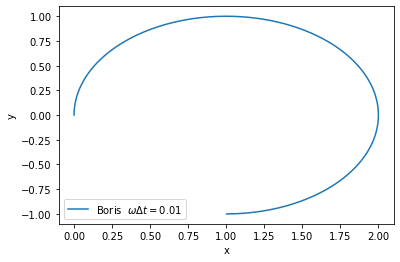

In [26]:
"""Graph generator"""
t_final = 1.5*np.pi
N = int(round((t_final-t_initial)/dt))      # total number of time steps
t = np.linspace(t_initial, t_final, N+1) 
fig, ax = plt.subplots()
r, v = Boris(r0, v0, t_initial, t_final, 0.01,B_field_Constant,E_field_None)
ax.plot(r[:, 0], r[:, 1],label = "Boris $\ \omega \Delta t = 0.01$")
#ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend()

array([0.15915494])

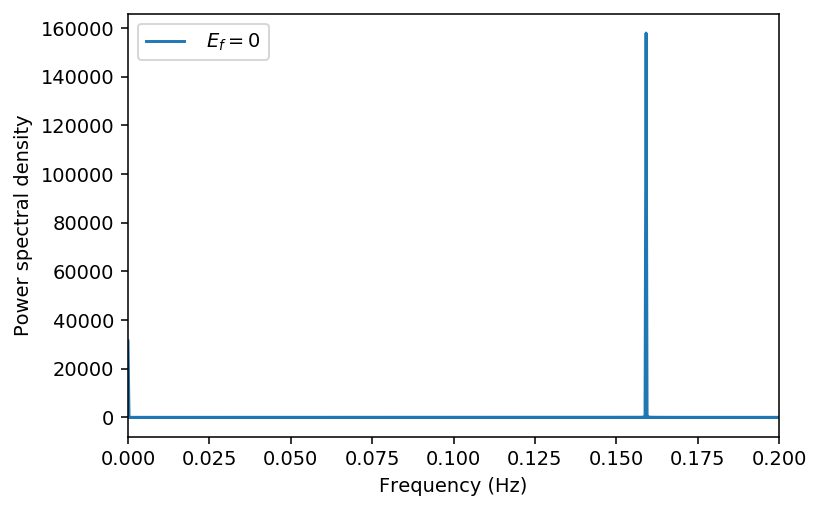

In [239]:
"""Frequency diagram generator"""
FT(t,r[:,1])

C:\Users\16098\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


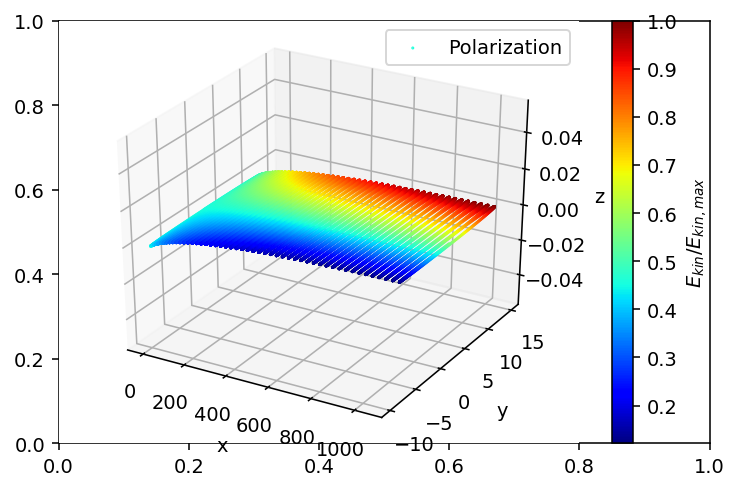

In [317]:
"""3d projection of motion with energy colormap"""
B_field = B_field_Constant
E_field = E_field_None

N = int(round((t_final-t_initial)/dt))      # total number of time steps
t = np.linspace(t_initial, t_final, N+1) 
Bf = np.zeros((N+1, 3))          # Magnetic field the particle sees
Ef = np.zeros((N+1, 3))          # Electric field the particle sees


for i in range(len(t)):
    Bf[i] = B_field(t[i], r[i])  
    Ef[i] = E_field(t[i], r[i])   

x_plot_min = np.min(r[:, 0])         
x_plot_max = np.max(r[:, 0])          
x_plot = np.linspace(x_plot_min, x_plot_max, N+1)   # x for plotting purposes

B_plot = np.zeros((N+1, 3))    # Magnetic field for plotting purposes
E_plot = np.zeros((N+1, 3))    # Electric field for plotting purposes

for i in range(len(t)):
    B_plot[i] = B_field(t[i], [x_plot[i], 0, 0])
    E_plot[i] = E_field(t[i], [x_plot[i], 0, 0])
    
Bup = 1
rf = 4
E0 = 0.1
B0 = 0.5*(Bup + rf*Bup)
B1 = 0.5*(-Bup + Bup*rf)
Bz = B0 + B1*np.tanh(r[:, 0])
dBz = B1/(np.cosh(r[:, 0])**2)


kin_energy = v[:, 0]**2 + v[:, 1]**2 + v[:, 2]**2

color1 = kin_energy/max(kin_energy)
color2 = t/t_final
#color3 = v[:, 2]/np.max(v[:, 2])


rL = max(v[0, 0], 0.1)

# calculate drifts
ExB = E0/Bz       #ExB drift
wperp2 = (v[:, 0] - ExB)**2 + v[:, 1]**2
gradb = wperp2/(2*qm)*1/(Bz)*dBz       # grad-B drift
gradb_pol = -E0**2/(qm*Bz**3)*dBz      # polarization drift

rL = max(v[0, 0], 0.1)

# Plotting the 3D trajectory of the particle
fig3, ax3 = plt.subplots()
ax3 = fig3.gca(projection='3d')
im = ax3.scatter(r[:, 0]/rL, r[:, 1]/rL, r[:, 2]/rL, c=color1, s=0.3, cmap = plt.cm.jet, label = "Polarization")
fig3.colorbar(im, ax=ax3, label=r"$E_{kin}/E_{kin, max}$")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
plt.legend()

In [332]:
def Stability(main, tested, r0,v0, t_initial, t_final, dt,B_field,E_field):
    """Stability analysis for all algorithms. There is a main function that inputs the function used as a benchmark
    which is either the analytical solution or the solution of Boris."""
    ro, vo = main(r0, v0, t_initial, t_final, dt,B_field,E_field)
    r,v = tested(r0, v0, t_initial, t_final, dt,B_field,E_field)
    N = int(round((t_final-t_initial)/dt))      # total number of time steps
    t = np.linspace(t_initial, t_final, N+1) 
    
    error_r = []
    error_r.append(t)
    error_r.append(abs(np.array(ro)-np.array(r))) #Error in r. 3-d vector
    
    error_v = []
    error_v.append(t)
    error_v.append(abs(np.array(vo)-np.array(v))) #Error in v. 3-d vector. Not used
    
    energy2 = []
    energy2.append(t)
    energy2.append(0.5*((np.array(v[:,0])-np.array(vo[:,0]))**2+(np.array(v[:,1])-np.array(vo[:,1]))**2+(np.array(v[:,2])-np.array(vo[:,2]))**2))
    #Relative energy conservation
    
    energy = []
    energy.append(t)
    energy.append(0.5*((np.array(v[:,0]))**2+(np.array(v[:,1]))**2+(np.array(v[:,2]))**2))
    #Absolute energy conservation
    
    AmpFactorR = []
    AmpFactorR.append(t[:len(t)-1])
    temp = []
    for i in range(0,len(t)-1):
        temp.append(r[:,0][i+1]-r[:,0][i])
    AmpFactorR.append(temp)
    #Amplification factor in R. Not used
    
    AmpFactorV = []
    AmpFactorV.append(t[:len(t)-1])
    temp = []
    for i in range(0,len(t)-1):
        temp.append(np.sqrt((v[:,0][i+1]-v[:,0][i])**2+(v[:,1][i+1]-v[:,1][i])**2+(v[:,2][i+1]-v[:,2][i])**2))
    AmpFactorV.append(temp)
    #Amplification factor in V. Not used

    return error_r,error_v,energy,energy2, AmpFactorR, AmpFactorV

In [249]:
def Convergence(main, tested, r0,v0, t_initial, t_final, dts,B_field,E_field):
    """Runs stability analysis for multipde dts"""
    Stabs = []
    for i in range(0,len(dts)):
        Stabs.append(Stability(main, tested, r0,v0, t_initial, t_final, dts[i],B_field,E_field))
    return Stabs

In [250]:
Stabs = Convergence(Analytical, RK4, r0,v0, t_initial, t_final, [0.01,0.05,0.1,0.3,0.5,1],B_field_Space,E_field_None)

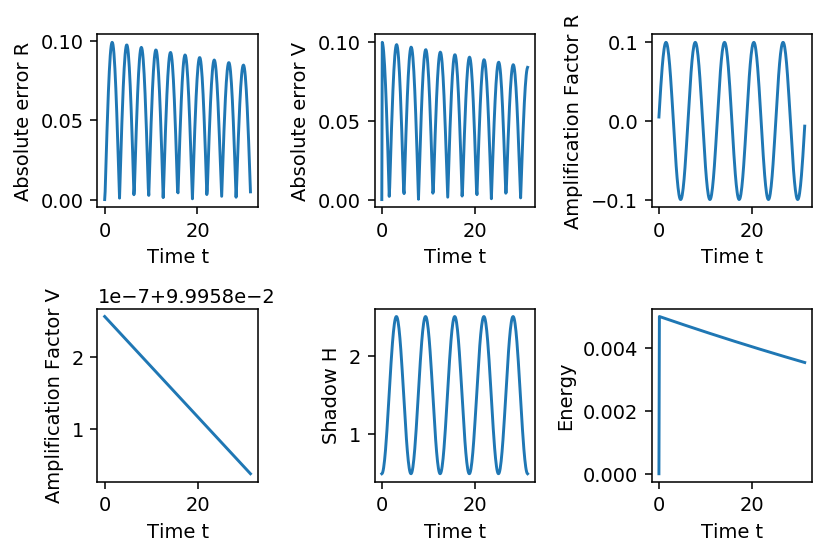

In [150]:
"""Generates graphs for stability analysis"""
error_r,error_v,energy,energy2, AmpFactorR, AmpFactorV = Stabs[2]
fig = plt.figure()

plt.subplot(2, 3, 1)
plt.plot(error_r[0],error_r[1][:,0],label = "position x-axis")
plt.xlabel("Time t")
plt.ylabel("Absolute error R")

plt.subplot(2, 3, 2)
plt.plot(error_v[0],error_v[1][:,0],label = "velocity x-axis")
plt.xlabel("Time t")
plt.ylabel("Absolute error V")

plt.subplot(2, 3, 3)
plt.plot(AmpFactorR[0],AmpFactorR[1])
plt.xlabel("Time t")
plt.ylabel("Amplification Factor R")

plt.subplot(2, 3, 4)
plt.plot(AmpFactorV[0],AmpFactorV[1])
plt.xlabel("Time t")
plt.ylabel("Amplification Factor V")

plt.subplot(2, 3, 5)
plt.plot(ShadHam[0],ShadHam[1])
plt.xlabel("Time t")
plt.ylabel("Energy2")

plt.subplot(2, 3, 6)
plt.plot(energy[0],energy[1])
plt.xlabel("Time t")
plt.ylabel("Energy")

plt.tight_layout()
plt.show()

In [328]:
t_final = 100*np.pi
StabEuler = Convergence(Boris, Leapfrog, r0,v0, t_initial, t_final, [0.01,0.05,0.1,0.3,0.5,1],B_field_,E_field_None)
StabLeapfrog = Convergence(Boris, RK4, r0,v0, t_initial, t_final, [0.01,0.05,0.1,0.3,0.5,1],B_field_Space,E_field_None)

In [329]:
error_r1,error_v,energy1,energy2, AmpFactorR1, AmpFactorV = StabEuler[0]
error_r2,error_v,energy2,energy2, AmpFactorR2, AmpFactorV = StabLeapfrog[0]
error_r3,error_v,energy3,energy2, AmpFactorR3, AmpFactorV = StabEuler[2]
error_r4,error_v,energy4,energy2, AmpFactorR4, AmpFactorV = StabLeapfrog[2]
error_r5,error_v,energy5,energy2, AmpFactorR5, AmpFactorV = StabEuler[4]
error_r6,error_v,energy6,energy2, AmpFactorR6, AmpFactorV = StabLeapfrog[4]


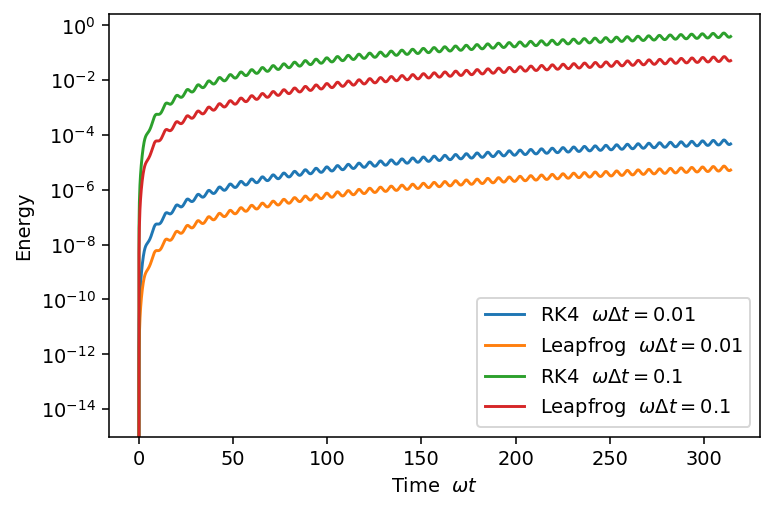

In [331]:
"""Generates graphs"""
plt.semilogy(energy1[0],energy1[1],label = "RK4 $\ \omega \Delta t = 0.01$")
plt.semilogy(energy2[0],energy2[1],label = "Leapfrog $\ \omega \Delta t = 0.01$")
plt.semilogy(energy3[0],energy3[1],label = "RK4 $\ \omega \Delta t = 0.1$")
plt.semilogy(energy4[0],energy4[1],label = "Leapfrog $\ \omega \Delta t = 0.1$")
#plt.semilogy(energy5[0],energy5[1],label = "RK4 $\ \omega \Delta t = 0.5$")
#plt.semilogy(energy6[0],energy6[1],label = "Leapfrog $\ \omega \Delta t = 0.5$")
plt.xlabel("Time $\ \omega t$")
plt.ylabel("Energy")
#plt.ylim([0.49999999,0.50000001])
plt.legend()